In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
#bibliotecas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc


import warnings
warnings.filterwarnings('ignore')


## 1. Lectura y concatenación de los Dataset

In [2]:
#cargar los datos
building_met = pd.read_csv("building_metadata.csv")
train = pd.read_csv("train.csv")
weather_train = pd.read_csv("weather_train.csv")

In [3]:
building_met

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [4]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [5]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [6]:
#Concatenamos los datos de train con building_met
train = train.merge(building_met,on = 'building_id',how = 'left')

In [8]:
#Contatenamos los datos con el dataset weather_train
train = train.merge(weather_train, on=['site_id','timestamp'], how='left')

In [9]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [10]:
#Función para obtener información de la variable timstamp como mes, dia de la semana, etc
def breakdown_timestamp(dataframe):
    
    dataframe['timestamp']= pd.to_datetime(dataframe['timestamp'])

    dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
    
    dataframe['day']= np.uint16(dataframe['timestamp'].dt.day)
    dataframe['dayofweek']= np.uint8(dataframe['timestamp'].dt.dayofweek)
    dataframe['dayofyear']= np.uint16(dataframe['timestamp'].dt.dayofyear)

    dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)

    dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
    
    return dataframe

In [11]:
train = breakdown_timestamp(train)

In [12]:
train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year
0,0,0,2016-01-01 00:00:00,0.000,0,Education,7432,2008.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
1,1,0,2016-01-01 00:00:00,0.000,0,Education,2720,2004.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
2,2,0,2016-01-01 00:00:00,0.000,0,Education,5376,1991.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
3,3,0,2016-01-01 00:00:00,0.000,0,Education,23685,2002.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
4,4,0,2016-01-01 00:00:00,0.000,0,Education,116607,1975.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,...,-1.0,1008.5,180.0,8.8,23,31,5,366,12,2016
20216096,1445,0,2016-12-31 23:00:00,4.825,15,Education,4298,NaN,NaN,1.7,...,-1.0,1008.5,180.0,8.8,23,31,5,366,12,2016
20216097,1446,0,2016-12-31 23:00:00,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,...,-1.0,1008.5,180.0,8.8,23,31,5,366,12,2016
20216098,1447,0,2016-12-31 23:00:00,159.575,15,Lodging/residential,29775,2001.0,NaN,1.7,...,-1.0,1008.5,180.0,8.8,23,31,5,366,12,2016


## 2. Análisis de la variable objetivo (meter_reading)

<AxesSubplot:xlabel='meter_reading', ylabel='Density'>

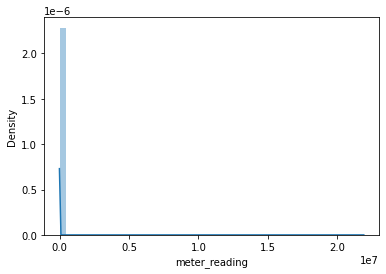

In [13]:
#Distribución de la variable objetivo
sns.distplot(train['meter_reading'])

In [14]:
print('Skewness de la variable objetivo', train['meter_reading'].skew())

Meter Reading has a skewness of 104.81131369454751


#### Observación:

1. La variable objetivo presenta una asimetria muy pronunciada hacia la izquierda.
2. Se puede arreglar esta asimetria aplicando una transformación logaritmica.

In [15]:
#transformación logaritmica de la variable objetivo
train['meter_reading']=np.log1p(train['meter_reading'])

<AxesSubplot:xlabel='meter_reading', ylabel='Density'>

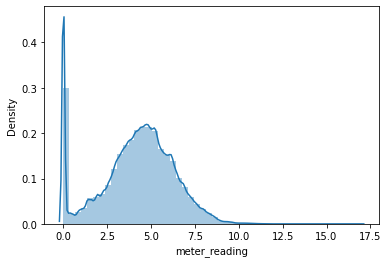

In [16]:
sns.distplot(train['meter_reading'])

In [17]:
print('Skewness de la variable transformada', train['meter_reading'].skew())

Meter Reading has a new skewness of -0.27537684241990795


Se puede observar que el valor más recurrente de la variable objetivo(meter_reading) es cero.

## 3. Exploración de variables

#### 3.1. Tipos de medidores

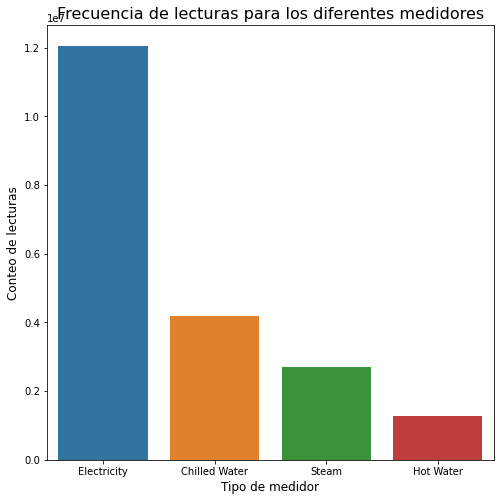

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
meter_types_labels = ['Electricity', 'Chilled Water', 'Steam', 'Hot Water']
sns.countplot(x = 'meter', data = train).set_title("Frecuencia de lecturas para los diferentes medidores", fontsize=16)
ax.set_xticklabels(meter_types_labels)
plt.xlabel('Tipo de medidor', fontsize=12)
plt.ylabel('Conteo de lecturas', fontsize=12)
plt.show()

Los medidores correspondientes a electricidad son los mas recurrentes, mientras que los de agua caliente son los menos usados.

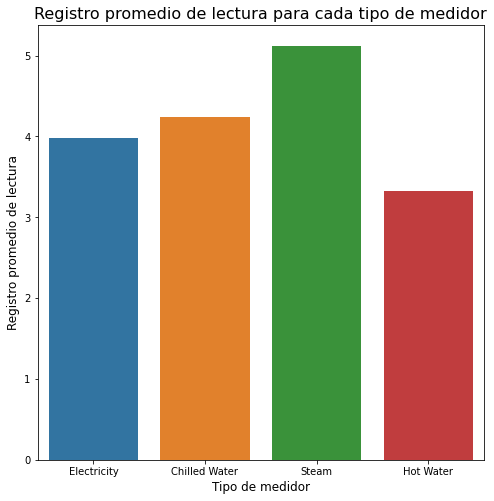

In [19]:
#
fig, ax = plt.subplots(figsize=(8,8))
meter_types = train.groupby('meter').meter_reading.mean().reset_index()
sns.barplot(x ='meter', y ='meter_reading', data = meter_types).set_title("Registro promedio de lectura para cada tipo de medidor",
                                                                                                          fontsize=16)
ax.set_xticklabels(meter_types_labels)
plt.xlabel('Tipo de medidor', fontsize=12)
plt.ylabel('Registro promedio de lectura', fontsize=12)
plt.show()

Los medidores de vapor ("steam") son los que presentan los valores de consumo de energía más altos. Por su parte, los medidores de agua caliente ("Hot Water") son los que presentan los valores menores.

#### 3.2. Usos primarios

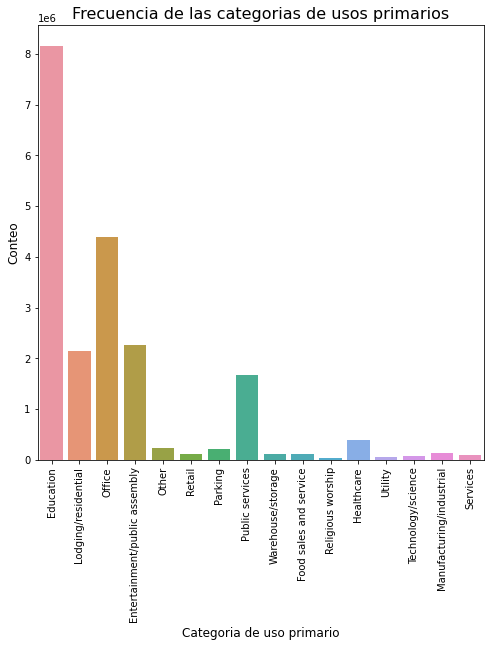

In [20]:
plt.figure(figsize=(8,8))
sns.countplot(x = 'primary_use', data = train).set_title("Frecuencia de las categorias de usos primarios", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Categoria de uso primario', fontsize=12)
plt.ylabel('Conteo', fontsize=12)
plt.show()

Las edificaciones referentes a aplicaciones educacionales son las más frecuentes. Las edificaciones de aplicaciones religiosas son las menos frecuentes.

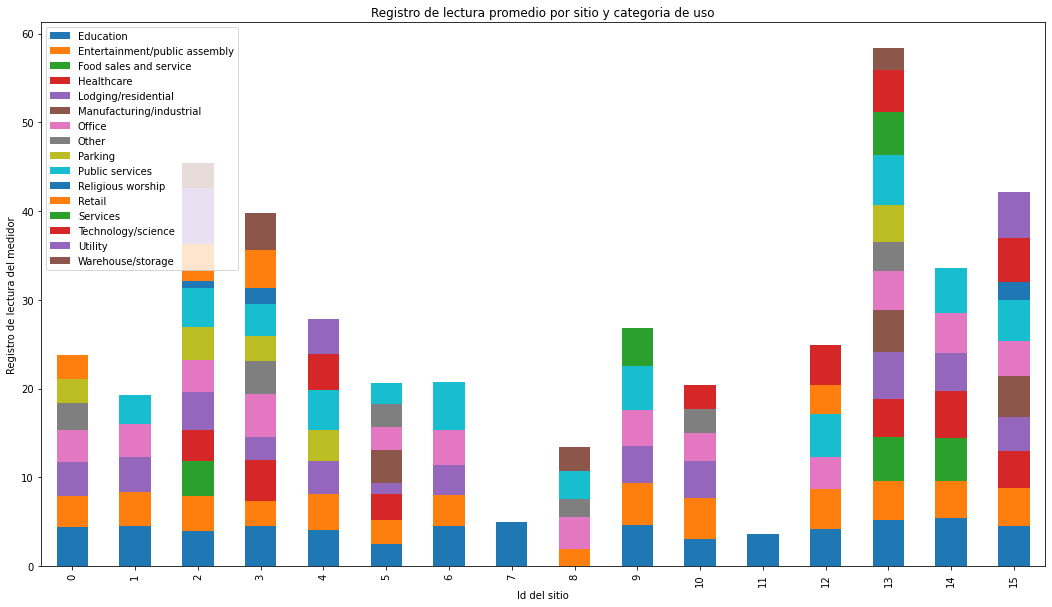

In [21]:
site_use_grouping = train.groupby(['site_id','primary_use'])['meter_reading'].mean().unstack('primary_use')
site_use_grouping.plot(kind = 'bar', stacked = True, figsize=(18,10)).set_title("Registro de lectura promedio por sitio y categoria de uso")
plt.xlabel('Id del sitio')
plt.ylabel('Registro de lectura del medidor')
plt.legend(loc = "upper left")
plt.show()

Se puede observar que el sitio 13 es el que tiene las mayores lecturas promedio de los medidores. Por su parte, el sitio 11 es el las menores lecturas promedio de medidores, y en este sitio las aplicaciones corresponden unicamente a edificaciones con uso educacional.

#### 3.3. Consumo de energía por mes y hora

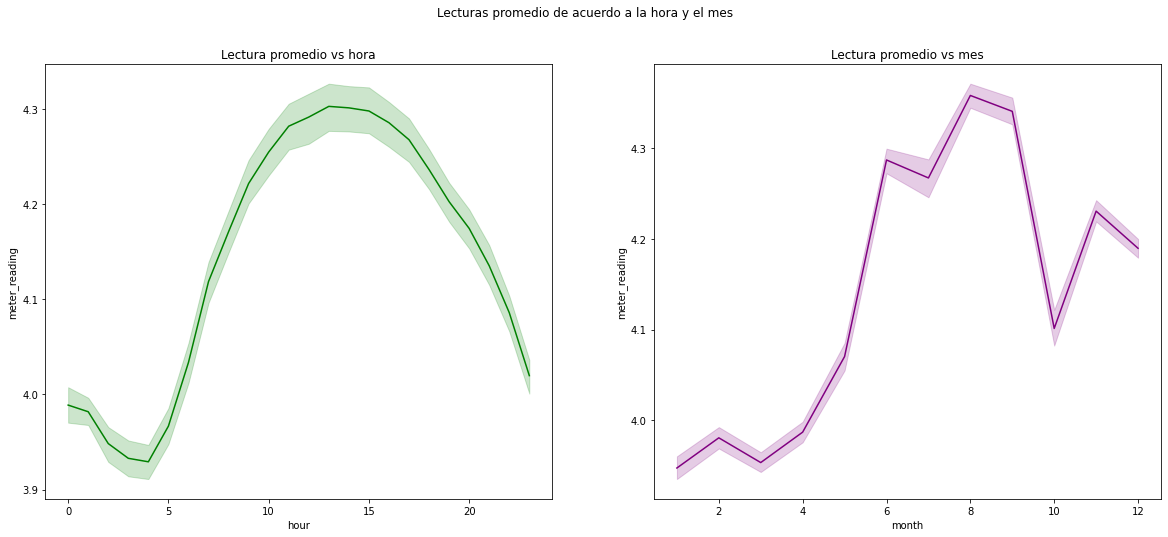

In [22]:
hour_groups = train.groupby(['timestamp','hour']).meter_reading.mean().reset_index()
month_groups = train.groupby(['timestamp','month']).meter_reading.mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Lecturas promedio de acuerdo a la hora y el mes')

sns.lineplot(x = hour_groups['hour'], y = hour_groups['meter_reading'], color='green', ax = ax1)
ax1.set_title('Lectura promedio vs hora')

sns.lineplot(x = month_groups['month'], y = month_groups['meter_reading'], color='purple', ax = ax2)
ax2.set_title('Lectura promedio vs mes')

plt.show()

##### Observaciones:

1. El consumo de energía cae en un rango que va aproximadamente desde la 1 AM hasta las 4 AM, siendo el valor mínimo aproximadamente a las 4 AM. Luego de esto el consumo de energía comienza a incrementar a partir de las 5 AM.

2. El consumo de enegía se maxima en el rango de las 12 PM a las 3 PM, presentando un valor pico alrededor de la 1 PM. Este valor tiene sentido ya que muchas instituciones estarán operando en estos horarios.

3. El consumo de energía es muy bajo en el periodo que va desde Enero a Marzo, presentando un valor mínimo en el mes de Marzo.

4. El consumo de energía presenta un crecimiento gradual desde el mes de Abril, y alcanza su valor pico en el mes de Agosto.

#### 3.4. Datos faltantes

In [23]:
#Porcentaje de datos faltantes para cada variable del dataset
total           = train.isnull().sum().sort_values(ascending=False)
percent         = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing_train  = pd.concat([total,percent],axis=1,keys=["Total","Percent"])
missing_train

,Total,Percent
floor_count,16709167,82.652772
year_built,12127645,59.990033
cloud_coverage,8825365,43.655131
precip_depth_1_hr,3749023,18.544739
wind_direction,1449048,7.167792
sea_level_pressure,1231669,6.092515
wind_speed,143676,0.710701
dew_temperature,100140,0.495348
air_temperature,96658,0.478124
month,0,0.000000


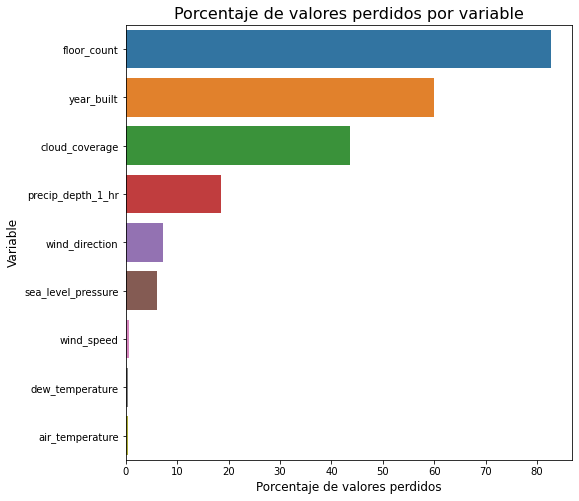

In [24]:
#Gráfico de los porcentajes de valores perdidos para las variables
plt.figure(figsize=(8,8))
sns.barplot(x = missing_train['floor_count':'air_temperature'].Percent,
                    y = missing_train.index[0:9]).set_title("Porcentaje de valores perdidos por variable", fontsize=16)
plt.xlabel('Porcentaje de valores perdidos', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.show()

##### Observaciones:

1. floor_count es la variable que presenta la mayor cantidad de datos faltantes, con un porcentaje de 82.6%.
2. year_built es la segunda variable con más datos faltantes, con un porcentaje de casi 60%.
3. Se deben tener en cuenta estos valores para realizar el tratamiento de datos más adelante.

#### 3.5. Correlación entre las diferentes variables

In [25]:
#Matriz de correlaciones
corr_matrix = train.corr()

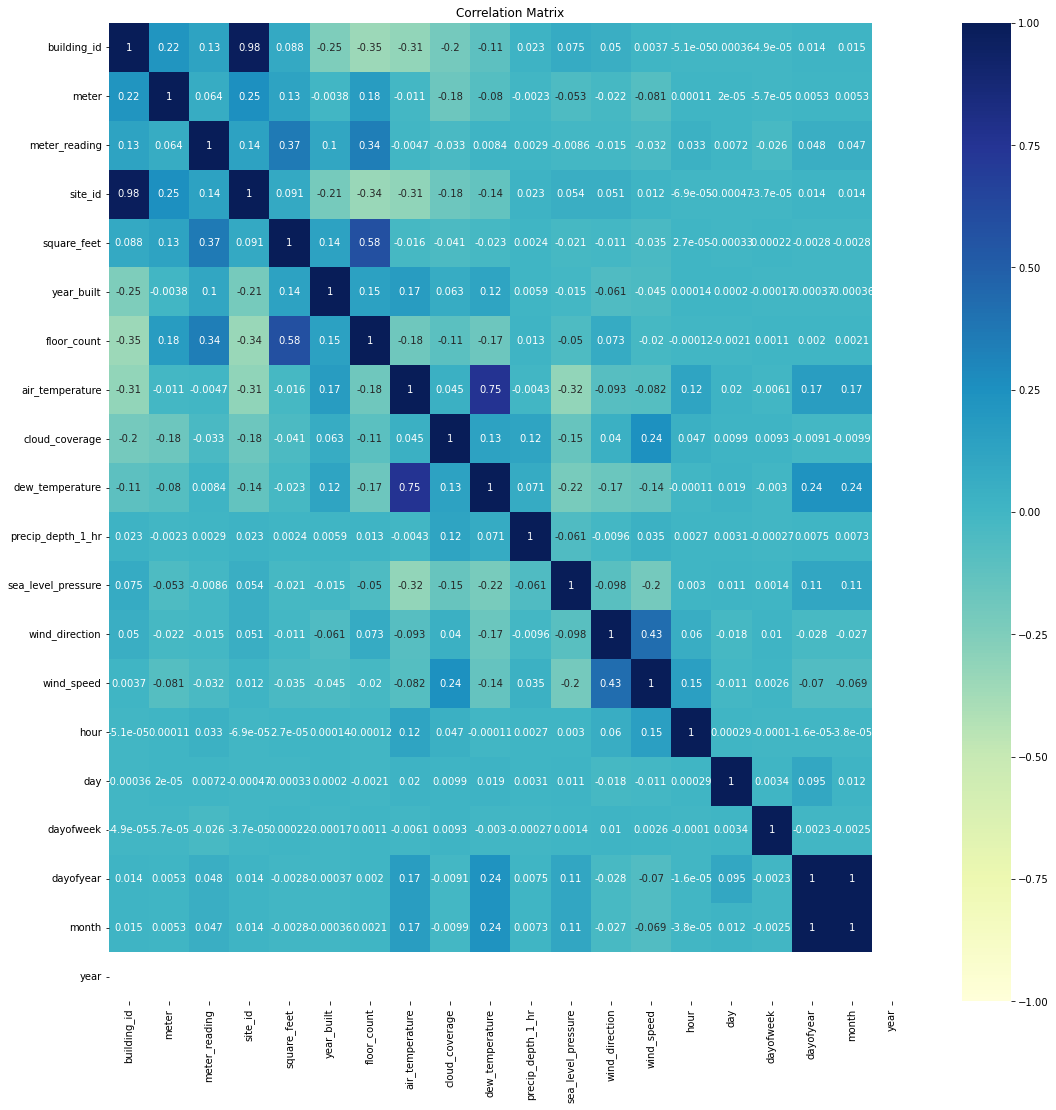

In [26]:
#Gráfico de la matriz de correlaciones
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [27]:
#Correlaciones de las variables con la variable objetivo
target_corr_df = pd.DataFrame(corr_matrix["meter_reading"].sort_values(ascending=False))
target_corr_df 

,meter_reading
meter_reading,1.000000
square_feet,0.366016
floor_count,0.342052
site_id,0.139902
building_id,0.126395
year_built,0.103332
meter,0.064360
dayofyear,0.047776
month,0.047386
hour,0.033277


##### Observaciones:
1. Las variables "dew_temperature" y "air_temperature, tienen una alta correlación, aproximadamente de 0.8.
2. Las variables con la correlación más alta son "site_id" y "Building_id".
3. Al observar las correlaciones de las variables con la variable objetivo (meter_reading), se puede observar que la mayoría de las variables numéricas no tienen una alta correlación con esta.


#### 3.6 Distribución de las variables numéricas

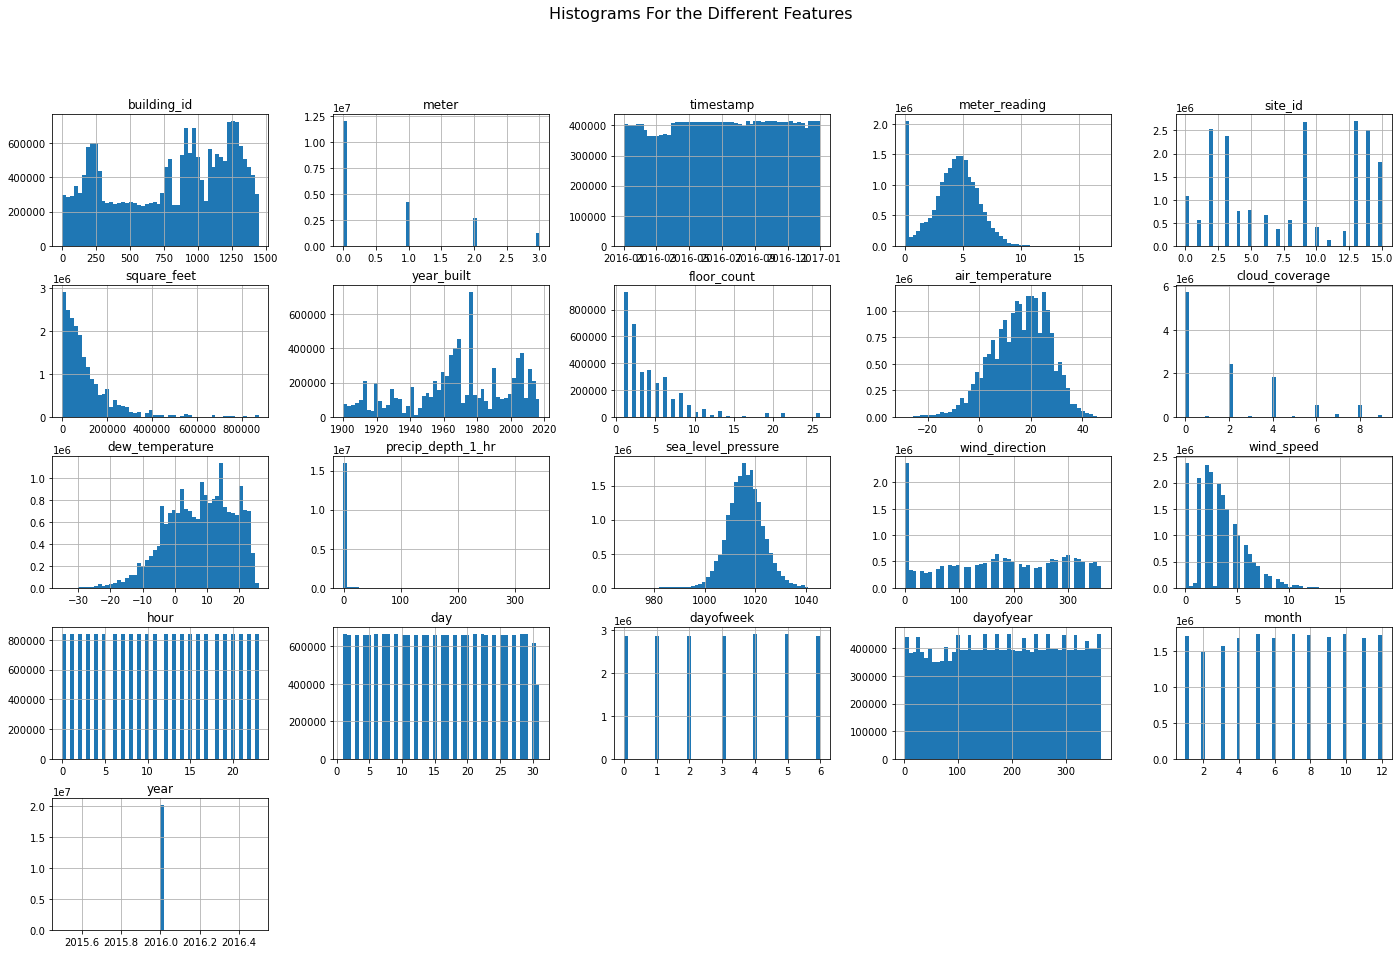

In [28]:
#Gráficos de los histogramas de las distribuciones de las variables
train.hist(bins=50, figsize=(24,15))
plt.suptitle('Histograms For the Different Features', fontsize=16)
plt.show()

La variable "square_feet" tiene una desviación hacia la izquierda bastante pronunciada, se puede aplicar una transformación logaritmica para arreglarlo.

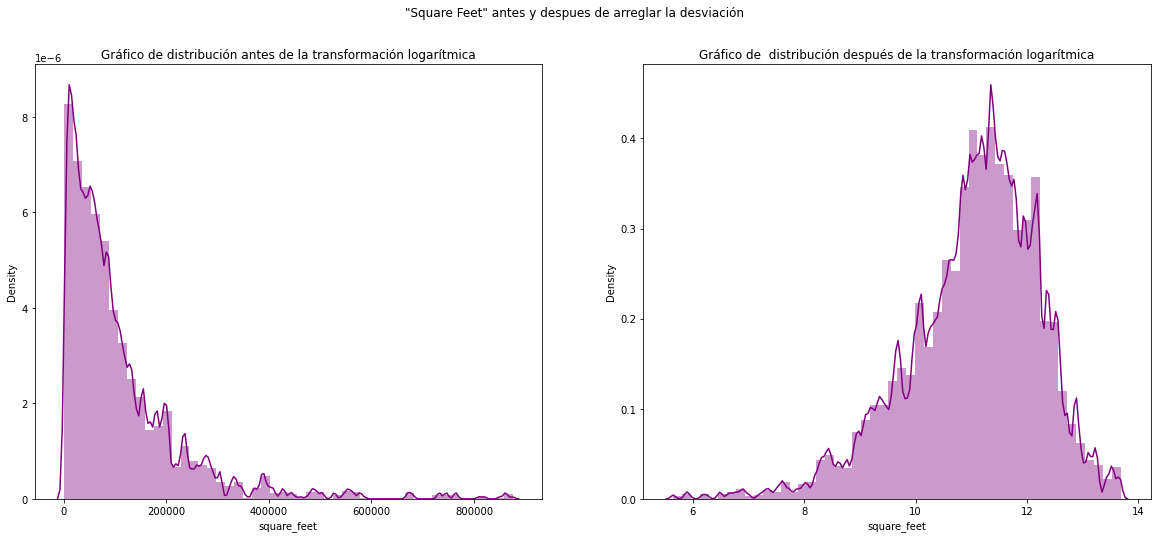

In [29]:
#Transformación logaritmica de la variable square_feet
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('"Square Feet" antes y despues de arreglar la desviación')

sns.distplot(train['square_feet'], color='purple', ax = ax1)
ax1.set_title('Gráfico de distribución antes de la transformación logarítmica')

sns.distplot(np.log1p(train['square_feet']), color='purple', ax = ax2)
ax2.set_title('Gráfico de  distribución después de la transformación logarítmica')

plt.show()

In [30]:
print('Desviación de "Square Feet" antes de la transformación logarítmica: ', train['square_feet'].skew())
train['square_feet'] = np.log1p(train['square_feet'])
print('Desviación de "Square Feet" despues de la transformación logarítmica ', train['square_feet'].skew())


Desviación de "Square Feet" antes de la transformación logarítmica:  2.6664165857123243
Desviación de "Square Feet" despues de la transformación logarítmica  -0.7811655719213683
